In [1]:
import PIL.Image
import torch
from perceiver_pytorch import PerceiverIO

In [2]:
device='cuda'
import sys
sys.path.append('../')

In [3]:
from train import create_model

model = create_model(**{
        'num_latents': 256,
        'num_latent_channels': 512,
        'vocab_size': 8192,
        'max_seq_len': 256,
        'num_decoder_cross_attention_heads': 1,
        'num_encoder_cross_attention_heads': 1,
        'dropout': 0.1,
        'num_encoder_layers': 6,
        'num_encoder_self_attention_layers_per_block': 6

    }).to(device).eval()

In [4]:
data = torch.load('../vqgan/runs/test_perceiver2/perceiver_checkpoint_94000.pt', map_location=device)

In [5]:
model.load_state_dict(data['model'])

<All keys matched successfully>

In [6]:
from omegaconf import OmegaConf

config = OmegaConf.load('../vqgan/config/ffhq_256_transformer_f16_8192.yml')

In [7]:
import vqgan.models.vqgan

vqgan_model = vqgan.models.vqgan.make_model_from_config(config.model.vqgan).eval().to(device)
vqgan_model.load_from_file('../vqgan/' + config.model.vqgan.checkpoint_path)

resolution for layer 0: 256
resolution for layer 1: 128
resolution for layer 2: 64
resolution for layer 3: 32
resolution for layer 4: 16
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


In [208]:
image = PIL.Image.open('/home/lleonard/dev/perso/stylegan2-ada-pytorch/aligned_images/Macron_01.png').resize((256, 256)).convert('RGB')
import numpy as np
image = np.array(image).astype(np.uint8)
image = (image / 127.5 - 1.0).astype(np.float32)
image = torch.tensor(image).permute(2, 0, 1).to(device)

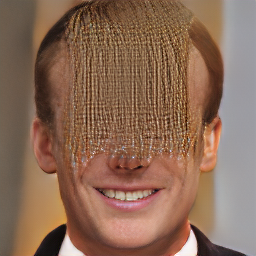

In [233]:
from vqgan.train_perceiver2 import generate_from_indices
import torchvision
quantized, indices, _ = vqgan_model.encode(image.unsqueeze(0))
#indices = torch.randint_like(indices, 0, 8191)
indices = indices.squeeze(0)
#mask = torch.randn_like(indices.float()).to(device)
#mask = mask < 0.05
mask = torch.zeros_like(indices.float()).to(device)
mask[1:10:, 4:12] = 1
mask = mask.bool()
indices[mask] = 2

masked_image = generate_from_indices(indices, vqgan_model)
torchvision.transforms.ToPILImage()(masked_image)

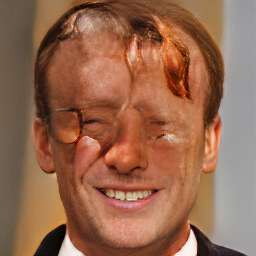

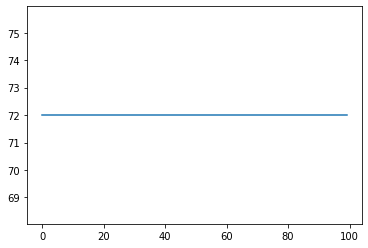

In [235]:
import torch.nn.functional as F
from einops import rearrange
from IPython.display import display, clear_output
local_indices = indices.clone()
import imageio
import matplotlib.pyplot as plt

sample=True
temperature = 1.0
images = []
# mask = torch.zeros_like(indices.float()).to(device)
# mask[9:14:, 4:15] = 1
# mask = mask.bool()
histo = []
histo2 = []
for i in range(100):
    histo.append(mask.sum().detach().cpu().item())


    logits, targets = model(torch.flatten(local_indices).unsqueeze(0),
                            torch.zeros(torch.flatten(local_indices).unsqueeze(0).shape).to(device).bool(),
                            masking=False)
    logits = rearrange(logits, 'b m c -> b c m')
    logits = logits[0] / temperature
    probs = F.softmax(logits.permute(1, 0), dim=-1)

    if sample:
        ix = torch.multinomial(probs, num_samples=1).squeeze(-1)
    else:
        _, ix = torch.topk(probs, k=5, dim=-1)
        ix = ix[:, 1]
    generated_indices = ix.reshape(16, 16)
    histo2.append(probs.mean(dim=-1).sum().detach().cpu().item())
    #mask[probs.max(dim=-1).values.view(16, 16) > 0.12] = 0
    generated_indices = local_indices * ~mask + generated_indices * mask
    unmasked_image = generate_from_indices(generated_indices, vqgan_model)
    local_indices = generated_indices
    clear_output(wait=True)

    #images.append()
    display(torchvision.transforms.ToPILImage()(unmasked_image))
plt.plot(histo)
#imageio.mimsave('./test.gif', images)